# Laboratorio 4 - Análisis Geoespacial
**Repositorio:** https://github.com/DiegoLinares11/Lab-4-Analisis-Geoespacial

- Diego Linares
- José Prince

## Conexión y AOIs

In [15]:
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from rasterio.enums import Resampling
import openeo
from datetime import date

# 1) Conexión (punto 1 del PDF)
connection = openeo.connect("https://openeo.dataspace.copernicus.eu").authenticate_oidc()

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Authenticated using refresh token.


 2) AOIs del PDF

In [16]:
lago_atitlan = {"west": -91.326256, "east": -91.07151, "south": 14.5948,  "north": 14.750979}
lago_amatitlan = {"west": -90.638065, "east": -90.512924, "south": 14.412347, "north": 14.493799}

 3) Fechas (>= 6 meses, usar baja nubosidad)


In [17]:
good_dates = [
"2025-02-07","2025-02-10","2025-02-25","2025-02-27","2025-03-02","2025-03-04","2025-03-07","2025-03-09",
"2025-03-12","2025-03-14","2025-03-19","2025-03-22","2025-03-24","2025-03-26","2025-04-03","2025-04-11",
"2025-04-13","2025-04-15","2025-04-16","2025-04-18","2025-04-28","2025-05-03","2025-05-13","2025-05-28",
"2025-07-10","2025-07-17","2025-07-20","2025-07-24","2025-08-01"
]

In [18]:

BANDS = ["B02","B03","B04","B05","B08"]  # + B05 para NDCI

def download_s2(lake_name, bbox, d, offline=False):
    out = f"data/{lake_name}_{d}.tif"
    if os.path.exists(out) or offline:
        return out if os.path.exists(out) else None
    cube = connection.load_collection(
        "SENTINEL2_L2A",
        spatial_extent=bbox,
        temporal_extent=[d, d],
        bands=BANDS
    )
    res = cube.save_result(format="GTIFF")
    job = connection.create_job(res)
    job.start_and_wait()
    os.makedirs("data", exist_ok=True)
    job.download_results(out)
    return out

def normalize(b, nodata):
    b = b.astype(np.float32)
    mask = np.ones_like(b, bool) if nodata is None else (b != nodata)
    if not np.any(mask): return np.zeros_like(b, np.float32)
    lo, hi = np.percentile(b[mask], (2, 98))
    return np.clip((b - lo) / (hi - lo + 1e-6), 0, 1)

def read_bands(path):
    with rasterio.open(path) as src:
        arr = src.read()     # 0:B02 1:B03 2:B04 3:B05 4:B08
        nod = src.nodata
    return arr, nod

def compute_indices(arr):
    B02, B03, B04, B05, B08 = arr
    # escala a reflectancia si viene en entero
    if B04.dtype != np.float32 and B04.max() > 1.5:
        B02 = B02.astype(np.float32)/10000; B03 = B03.astype(np.float32)/10000
        B04 = B04.astype(np.float32)/10000; B05 = B05.astype(np.float32)/10000; B08 = B08.astype(np.float32)/10000
    # índices (punto 5→numpy y 8→correlación NDVI/NDWI) :contentReference[oaicite:7]{index=7}
    ndvi = np.where((B08+B04)==0, np.nan, (B08-B04)/(B08+B04))
    ndwi = np.where((B03+B08)==0, np.nan, (B03-B08)/(B03+B08))
    ndci = np.where((B05+B04)==0, np.nan, (B05-B04)/(B05+B04))  # índice de cianobacteria
    return ndvi, ndwi, ndci

def show_true_color(arr, nodata, title):
    B02, B03, B04, *_ = arr
    rgb = np.dstack([normalize(B04, nodata), normalize(B03, nodata), normalize(B02, nodata)])
    plt.figure(figsize=(7,5)); plt.imshow(rgb); plt.title(title); plt.axis('off'); plt.show()

=== 4) DESCARGA y 5) Numpy ===

/tmp/ipykernel_4758/1612047133.py:40: RuntimeWarning: divide by zero encountered in divide
  ndvi = np.where((B08+B04)==0, np.nan, (B08-B04)/(B08+B04))
/tmp/ipykernel_4758/1612047133.py:40: RuntimeWarning: invalid value encountered in divide
  ndvi = np.where((B08+B04)==0, np.nan, (B08-B04)/(B08+B04))
/tmp/ipykernel_4758/1612047133.py:41: RuntimeWarning: divide by zero encountered in divide
  ndwi = np.where((B03+B08)==0, np.nan, (B03-B08)/(B03+B08))
/tmp/ipykernel_4758/1612047133.py:41: RuntimeWarning: invalid value encountered in divide
  ndwi = np.where((B03+B08)==0, np.nan, (B03-B08)/(B03+B08))
/tmp/ipykernel_4758/1612047133.py:42: RuntimeWarning: divide by zero encountered in divide
  ndci = np.where((B05+B04)==0, np.nan, (B05-B04)/(B05+B04))  # índice de cianobacteria
/tmp/ipykernel_4758/1612047133.py:42: RuntimeWarning: invalid value encountered in divide
  ndci = np.where((B05+B04)==0, np.nan, (B05-B04)/(B05+B04))  # índice de cianobacteria


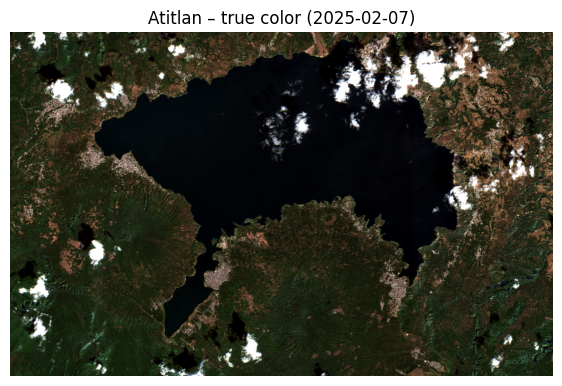

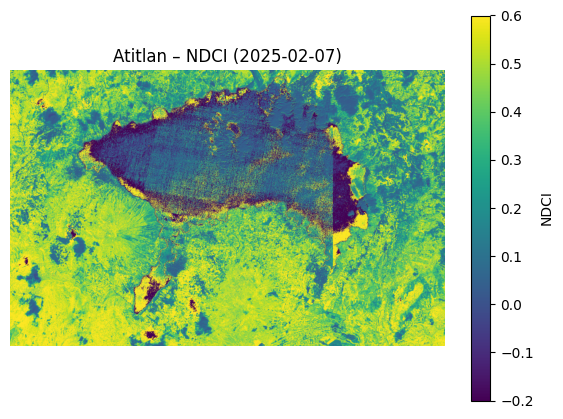

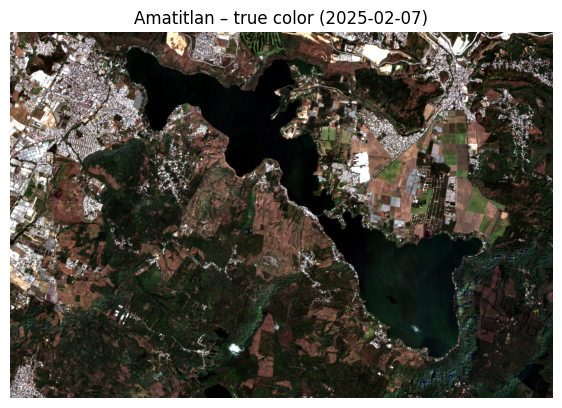

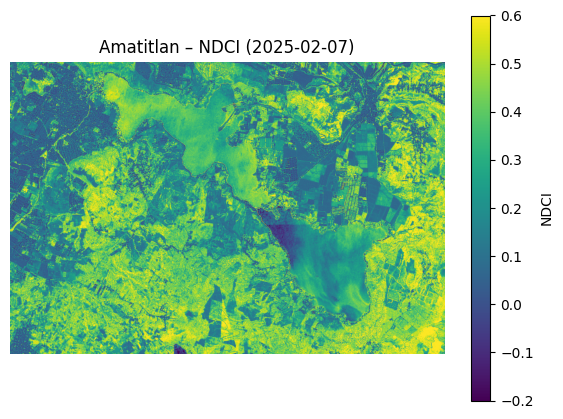

Saltando amatitlan 2025-02-10 invalid path or file: None
Saltando amatitlan 2025-02-25 invalid path or file: None
Saltando amatitlan 2025-03-02 invalid path or file: None
Saltando amatitlan 2025-03-07 invalid path or file: None
Saltando amatitlan 2025-03-12 invalid path or file: None
Saltando amatitlan 2025-03-22 invalid path or file: None
Saltando amatitlan 2025-04-11 invalid path or file: None
Saltando amatitlan 2025-04-16 invalid path or file: None
Saltando amatitlan 2025-07-10 invalid path or file: None
Saltando amatitlan 2025-07-20 invalid path or file: None


In [19]:
def process_lake(lake_name, bbox):
    rows = []
    for d in good_dates:
        try:
            tif = download_s2(lake_name, bbox, d, offline=True)  # puntos 1–2–3–4–5 del PDF
            arr, nod = read_bands(tif)
            ndvi, ndwi, ndci = compute_indices(arr)
            # guarda métricas promedio (punto 6.1)
            rows.append({"date": d,
                         "ndvi_mean": np.nanmean(ndvi),
                         "ndwi_mean": np.nanmean(ndwi),
                         "ndci_mean": np.nanmean(ndci)})
            # primer render por lago (true color)
            if d == good_dates[0]:
                show_true_color(arr, nod, f"{lake_name.capitalize()} – true color ({d})")
                plt.figure(figsize=(7,5)); plt.imshow(ndci, cmap="viridis", vmin=-0.2, vmax=0.6)
                plt.colorbar(label="NDCI"); plt.title(f"{lake_name.capitalize()} – NDCI ({d})")
                plt.axis('off'); plt.show()
        except Exception as e:
            print("Saltando", lake_name, d, e)
    return pd.DataFrame(rows).sort_values("date")

ts_atitlan   = process_lake("atitlan",   lago_atitlan)
ts_amatitlan = process_lake("amatitlan", lago_amatitlan)

In [20]:
from datetime import datetime, timedelta
import glob, re

def existing_dates(lake_name):
    files = glob.glob(f"data/{lake_name}_*.tif")
    got = set()
    for f in files:
        m = re.search(rf"{lake_name}_(\d{{4}}-\d{{2}}-\d{{2}})\.tif$", f)
        if m: got.add(m.group(1))
    return got

missing_atitlan   = [d for d in good_dates if d not in existing_dates("atitlan")]
missing_amatitlan = [d for d in good_dates if d not in existing_dates("amatitlan")]

print("Faltan Atitlán:", missing_atitlan)
print("Faltan Amatitlán:", missing_amatitlan)


Faltan Atitlán: []
Faltan Amatitlán: ['2025-02-10', '2025-02-25', '2025-03-02', '2025-03-07', '2025-03-12', '2025-03-22', '2025-04-11', '2025-04-16', '2025-07-10', '2025-07-20']


#### Intentar descargar los faltantes

In [21]:
# def fill_missing(lake_name, bbox, missing_dates):
#     ok, bad = [], []
#     for d in missing_dates:
#         p = download_s2(lake_name, bbox, d)  
#         if p: ok.append(d)
#         else: bad.append(d)
#     print(f"{lake_name}: recuperadas {len(ok)}, no logradas {len(bad)} ->", bad)
#     return ok, bad
#
# fill_missing("amatitlan", lago_amatitlan, missing_amatitlan)


Se intento ejecutar este codigo el cual dio error, entonces verificamos los datos y nos fuimos a verificarlos manualmente en copernicus y efectivamente para esos dias que no se descargaron es porque no existen datos para esos dias asi que trabajaremos con los que logramos descargar. 

## Análisis temporal

A continuación se va a relizar diferentes analisis con los datos previamente obtenidos para obtener un análisis preliminar sobre los datos. Primeramente se va a hacer un anaálisis sobre el **inidice promedio de cianobacteria por lago y por fecha**.

In [14]:
# Unir y guardar series de cada lago
ts_atitlan["lake"] = "atitlan"
ts_amatitlan["lake"] = "amatitlan"
ts = pd.concat([ts_atitlan, ts_amatitlan], ignore_index=True).sort_values(["lake","date"])
os.makedirs("out", exist_ok=True)
ts.to_csv("out/indices_timeseries.csv", index=False)
display(ts.head())
display(ts.tail())


,date,ndvi_mean,ndwi_mean,ndci_mean,lake
29,2025-02-07,0.454213,-0.424480,0.292999,amatitlan
30,2025-02-27,0.362638,-0.314651,0.193221,amatitlan
31,2025-03-04,0.412859,-0.374418,0.257697,amatitlan
32,2025-03-09,0.247370,-0.216523,0.128231,amatitlan
33,2025-03-14,0.252556,-0.223923,0.141182,amatitlan


,date,ndvi_mean,ndwi_mean,ndci_mean,lake
24,2025-07-10,0.205266,-0.173586,0.117497,atitlan
25,2025-07-17,0.390045,-0.331337,0.237919,atitlan
26,2025-07-20,0.243022,-0.214924,0.146986,atitlan
27,2025-07-24,0.439736,-0.290730,0.281450,atitlan
28,2025-08-01,0.594425,-0.469505,0.393129,atitlan


Para los lagos Atitlán y Amatitlán muestra patrones temporales y diferencias claras en la magnitud de las floraciones. En general, Amatitlán tiende a presentar valores de NDCI consistentemente más altos que Atitlán en la mayoría de las fechas, lo que sugiere una mayor presencia de clorofila y, por ende, mayor probabilidad de proliferación de cianobacterias.

A continuación se puede visualizar la evolución temporal de cada lago su ndci, ndvi y ndwi promedio, indicando sus picos de floración y fechas críticas.

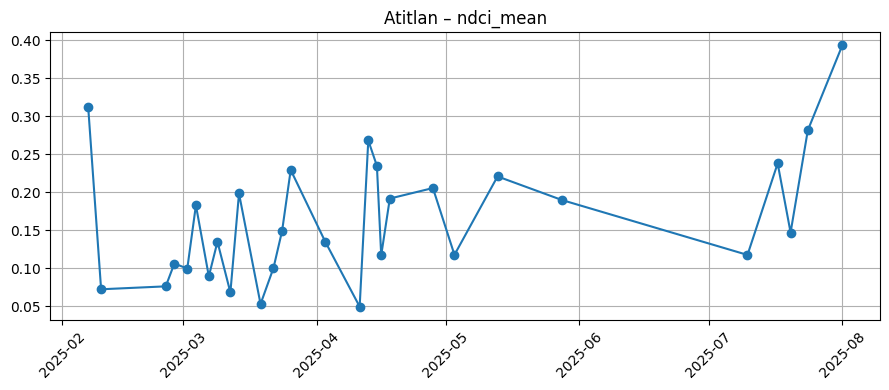

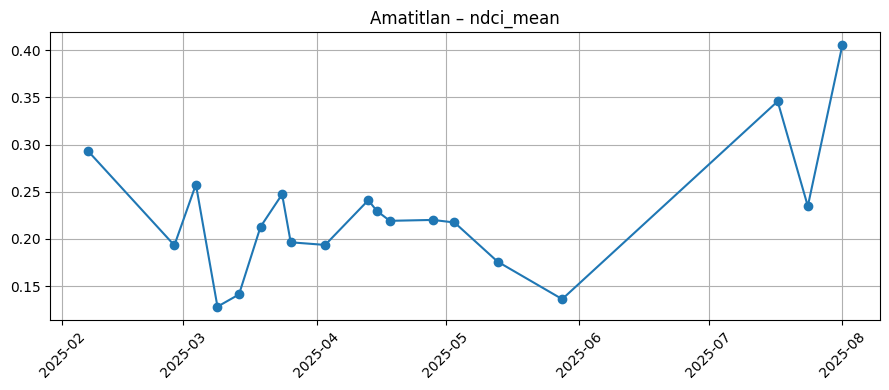

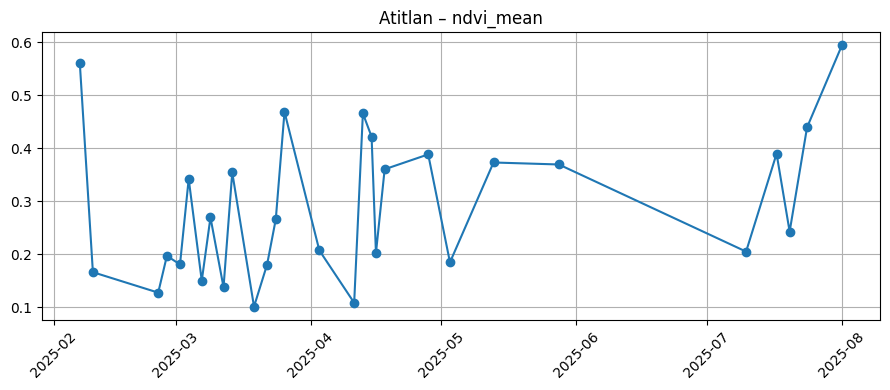

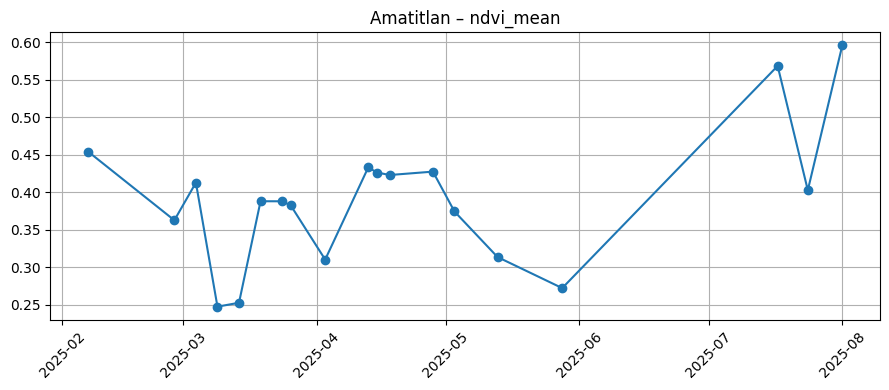

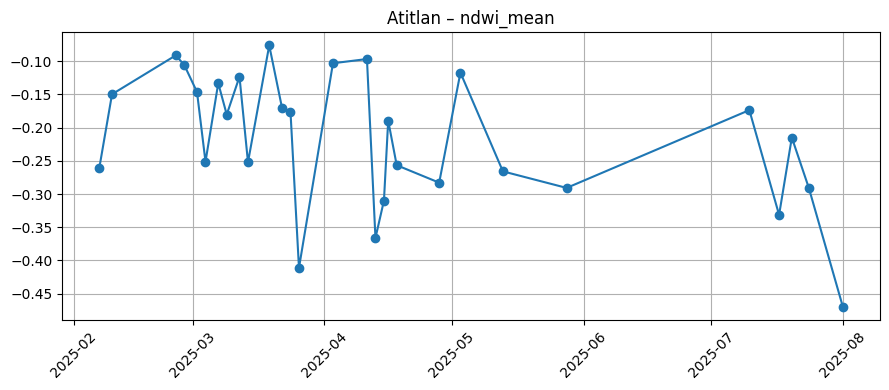

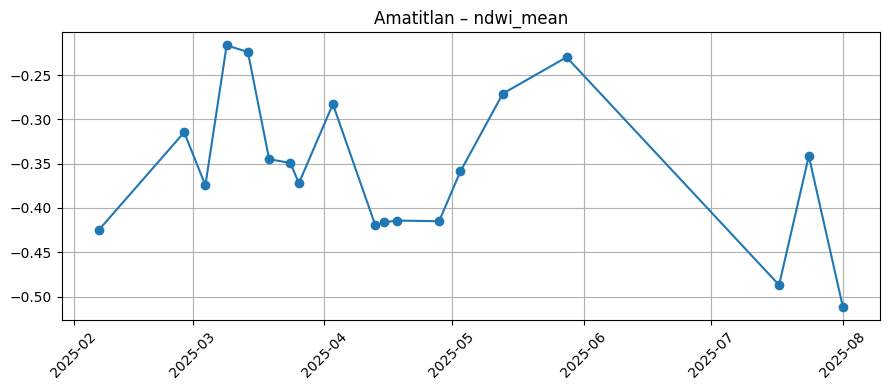

In [23]:
# Graficar series
def plot_series(df, lake, var):
    d = df[df["lake"]==lake].copy()
    x = pd.to_datetime(d["date"])
    plt.figure(figsize=(9,4))
    plt.plot(x, d[var], marker='o')
    plt.title(f"{lake.capitalize()} – {var}")
    plt.grid(True); plt.xticks(rotation=45); plt.tight_layout(); plt.show()

for var in ["ndci_mean","ndvi_mean","ndwi_mean"]:
    plot_series(ts, "atitlan", var)
    plot_series(ts, "amatitlan", var)



Amatitlán mantiene NDCI más alto en promedio (sugiere mayor Chl-a / condiciones más propensas a floración), y ambos lagos muestran picos fuertes a finales de julio–inicios de agosto.

#### NDVI
Atitlán: media 0.292, máx 0.594 (sube fuerte hacia fin de julio–agosto).

Amatitlán: media 0.391, máx 0.596 (también alza marcada en julio–agosto).

Lectura: en ambos lagos el NDVI sube en la misma época que NDCI (bordes con vegetación + posible materia flotante). Eso no prueba floración por sí solo, pero acompaña el patrón.

#### NDWI
Atitlán: media −0.217 (menos negativo que Amatitlán).

Amatitlán: media −0.356 (más negativo).

Lectura: NDWI medio más negativo en Amatitlán sugiere mayor fracción de suelo/urbano/orillas en el AOI (o agua “menos abierta” de forma agregada). Esto cuadra con que la caja/borde urbano del lago “contamina” la media si no enmascaras el espejo de agua.

## Mapas de NDCI

Se muestran la distribución de cianobacteria dentro de cada lago 

/tmp/ipykernel_4758/1612047133.py:40: RuntimeWarning: divide by zero encountered in divide
  ndvi = np.where((B08+B04)==0, np.nan, (B08-B04)/(B08+B04))
/tmp/ipykernel_4758/1612047133.py:40: RuntimeWarning: invalid value encountered in divide
  ndvi = np.where((B08+B04)==0, np.nan, (B08-B04)/(B08+B04))
/tmp/ipykernel_4758/1612047133.py:41: RuntimeWarning: divide by zero encountered in divide
  ndwi = np.where((B03+B08)==0, np.nan, (B03-B08)/(B03+B08))
/tmp/ipykernel_4758/1612047133.py:41: RuntimeWarning: invalid value encountered in divide
  ndwi = np.where((B03+B08)==0, np.nan, (B03-B08)/(B03+B08))
/tmp/ipykernel_4758/1612047133.py:42: RuntimeWarning: divide by zero encountered in divide
  ndci = np.where((B05+B04)==0, np.nan, (B05-B04)/(B05+B04))  # índice de cianobacteria
/tmp/ipykernel_4758/1612047133.py:42: RuntimeWarning: invalid value encountered in divide
  ndci = np.where((B05+B04)==0, np.nan, (B05-B04)/(B05+B04))  # índice de cianobacteria


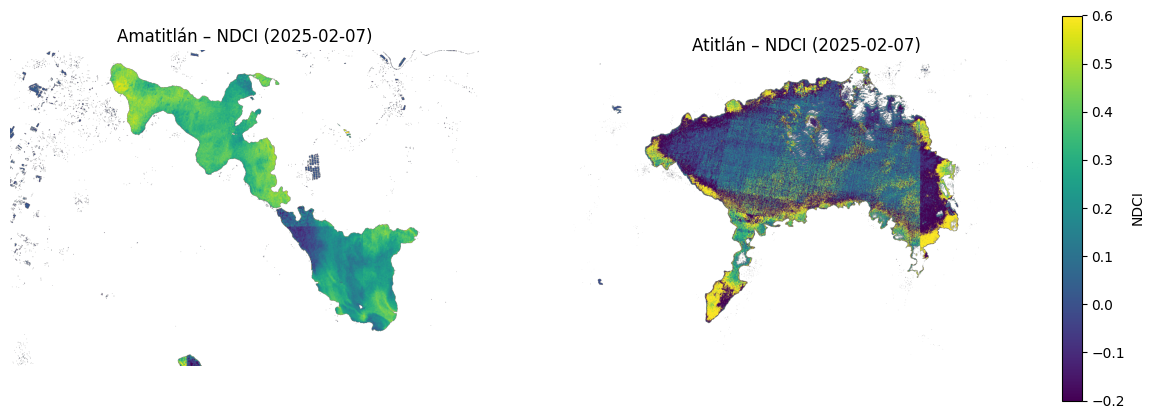

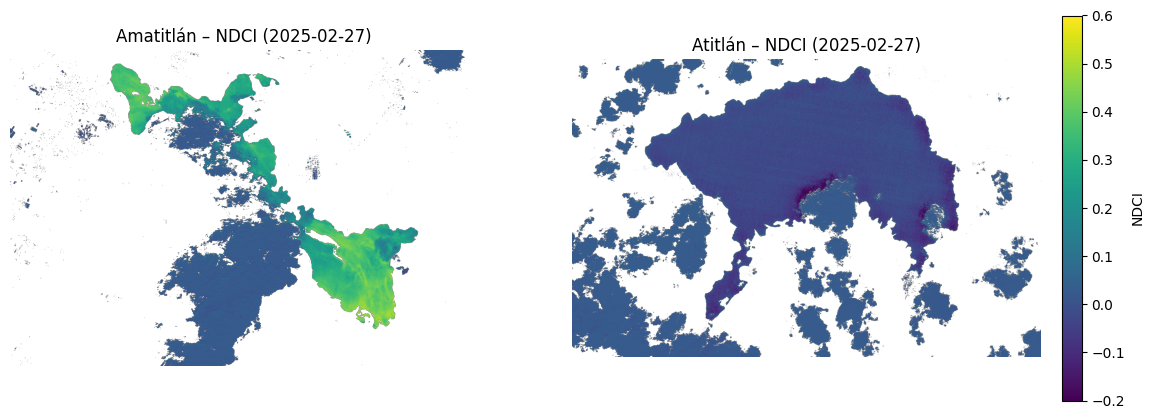

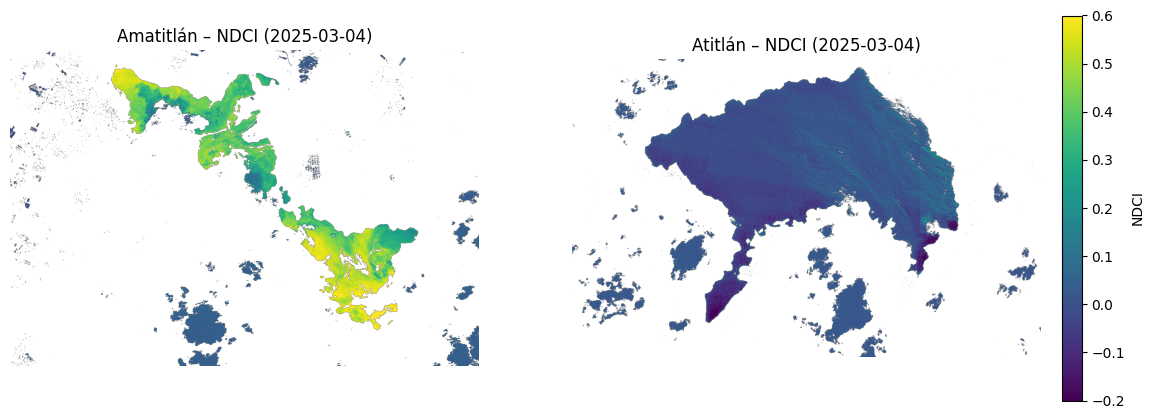

In [29]:
import glob, re

def list_tifs_dict(lake):
    """Devuelve un diccionario {fecha: ruta_tif} para un lago"""
    files = sorted(glob.glob(f"data/{lake}_*.tif"))
    d = {}
    for f in files:
        m = re.search(rf"{lake}_(\d{{4}}-\d{{2}}-\d{{2}})\.tif$", f)
        if m:
            d[m.group(1)] = f
    return d

def compute_ndci(path):
    arr, _ = read_bands(path)
    ndvi, ndwi, ndci = compute_indices(arr)
    ndci = np.where(ndwi > 0, ndci, np.nan)  # opcional: solo agua
    return ndci

def show_ndci_side_by_side(path1, title1, path2, title2):
    ndci1 = compute_ndci(path1)
    ndci2 = compute_ndci(path2)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    im1 = axes[0].imshow(ndci1, cmap="viridis", vmin=-0.2, vmax=0.6)
    axes[0].set_title(title1)
    axes[0].axis('off')

    im2 = axes[1].imshow(ndci2, cmap="viridis", vmin=-0.2, vmax=0.6)
    axes[1].set_title(title2)
    axes[1].axis('off')

    cbar = fig.colorbar(im1, ax=axes, orientation='vertical', fraction=0.03, pad=0.02)
    cbar.set_label("NDCI")

    plt.show()

tifs_atitlan = list_tifs_dict("atitlan")
tifs_amatitlan = list_tifs_dict("amatitlan")

fechas_comunes = sorted(set(tifs_atitlan.keys()) & set(tifs_amatitlan.keys()))

for fecha in fechas_comunes[:3]:  # ejemplo con las primeras 3 fechas
    show_ndci_side_by_side(
        tifs_amatitlan[fecha], f"Amatitlán – NDCI ({fecha})",
        tifs_atitlan[fecha],   f"Atitlán – NDCI ({fecha})"
    )

### Amatitlán

Se puede ver que para el 7 de febrero, el lago de Matitlán se muestra una distribución de cianobacterias moderada a alta en su superficie, con valores de NDCI entre 0.3 y 0.5. Para dinales del mes de febrero se aprecia una notable disminución en la presencia de cianobacterias, con la mayoría del lago mostrando valores cercanos a 0 o negativos, indicando una menor proliferanción. Para el 4 de marzo, se ve un resurgimiento de la cianobacteria, con una concentración alta, similar o incluso superior a la de la primera fecha.

### Atitlan

Para el lago de Atitlán se ve que para la primera fecha, el NDCI indicaba la presencia de cianobacterias en varias áreas. Para finales del mes, la proliferación de cianobacterias presenta una disminución, mostrando bajos indices de NDCI en diferentes partes del lago. Para principios de marzo, se observa un ligero aumento en la proliferación. Este lago presenta una concentración de cianobacterias menor a la de Amatitlán.

#### Correlación NDCI vs NDVI/NDWI

In [30]:
for lake in ["atitlan","amatitlan"]:
    d = ts[ts["lake"]==lake][["ndci_mean","ndvi_mean","ndwi_mean"]]
    print(f"Correlaciones {lake}:\n", d.corr(), "\n")


Correlaciones atitlan:
            ndci_mean  ndvi_mean  ndwi_mean
ndci_mean   1.000000   0.979356  -0.901963
ndvi_mean   0.979356   1.000000  -0.922880
ndwi_mean  -0.901963  -0.922880   1.000000 

Correlaciones amatitlan:
            ndci_mean  ndvi_mean  ndwi_mean
ndci_mean   1.000000   0.958622  -0.894787
ndvi_mean   0.958622   1.000000  -0.970648
ndwi_mean  -0.894787  -0.970648   1.000000 



Corr(NDCI, NDVI): Atitlán 0.98, Amatitlán 0.96 → muy positiva.

Corr(NDCI, NDWI): Atitlán −0.90, Amatitlán −0.89 → muy negativa.

Corr(NDVI, NDWI): Atitlán −0.92, Amatitlán −0.97 → muy negativa.

las medias se calcularon sobre todo el AOI (incluye tierra), no sólo agua. Con eso, cuando sube vegetación (NDVI ↑) en orillas/entorno, el NDWI (agua) baja y el NDCI puede subir (efecto mezcla/adyacencia + vegetación flotante).

## Análisis y comparación de los lagos

### Proliferación de cianobacteria (NDCI)

#### Atitlán

El NDCI promedio en el lago de Atitlán muestra una fluctuación a lo largo del período, con una tendencia de incremento notable a partir de julio, alcanzando su punto más alto a principios de agosto de 2025. Los datos confirman este patrón, mostrando un NDCI de 0.117 en julio y un pico de 0.393 a principios de agosto. Esto sugiere que las condiciones ambientales de los meses de verano favorecen la proliferación de estas bacterias.

NDCI medio = 0.165 (mediana 0.147; σ=0.084).

Pico: 0.393 el 2025-08-01 (final de época lluviosa).

Frecuencia (proxy de “evento”):

NDCI > 0.20 en 31% de las fechas.

NDCI > 0.30 en 6.9% de las fechas.

Estacionalidad (media mensual): febrero-marzo bajos (~0.13 – 0.14), aumento gradual en abril-mayo (~0.17 – 0.18) y salto fuerte en agosto (0.393).

Patrón espacial: parches altos en bahías y orillas; el centro del lago mantiene valores bajos-moderados.

#### Amatitlán

El lago de Amatitlán presenta una variabilidad considerable. A principios de febrero de 2025, el NDCI promedio es de 0.293, descendiendo a 0.193 a finales del mismo mes, Sin embargo, a principios de marzo, el índice vuelve a subir a 0.258. AL igual que en Atitlán, las series de tiempo indican que el NDCI tiende a aumentar hacia los meses de julio y agosto alcanzando vaores más altos en comparación con los meses de invierno.

NDCI medio = 0.226 (mediana 0.219; σ=0.068).

Pico: 0.405 el 2025-08-01.

Frecuencia:

NDCI > 0.20 en 63% de las fechas.

NDCI > 0.30 en 10.5% de las fechas.

Estacionalidad: febrero relativamente alto (0.243), valle en mayo (0.177) y alza marcada en julio (0.290)–agosto (0.405).

Patrón espacial: franjas amplias con NDCI moderado-alto cerca de la ribera; más homogéneo que Atitlán en las fechas pico.

Nota: los promedios por fecha se calcularon sobre el AOI completo; los mapas se muestran “solo agua” con NDWI>0. Para un análisis más “agua pura” a nivel de serie, puede repetirse el promedio con máscara de agua (NDWI/MNDWI) como robustez.



### Intensidad y frecuencia de floraciones

Intensidad promedio: Amatitlán > Atitlán
(0.226 vs 0.165; además, el pico de Amatitlán es apenas mayor: 0.405 vs 0.393).

Frecuencia (fechas por encima de umbrales):

0.20: 63% Amatitlán vs 31% Atitlán.

0.30: 10.5% Amatitlán vs 6.9% Atitlán.
⇒ Amatitlán presenta floraciones más frecuentes y sostenidas.

Temporalidad compartida: ambos concentran máximos a fines de julio–inicios de agosto (época lluviosa), con un alto temprano el 2025-02-07.

Variabilidad: Atitlán muestra más variación inter-fecha (σ=0.084 vs 0.068), coherente con un patrón espacial más parcheado.

### Posibles causas y diferencias

Morfometría e hidrología

Atitlán: lago profundo de caldera, mayor volumen y capacidad de dilución; menos intercambio con zonas urbanas densas → tendencia a picos localizados y respuesta más “puntual”.

Amatitlán: más somero y pequeño, cuenca altamente urbanizada (descargas y escorrentía más intensas) → enriquecimiento de nutrientes más rápido y parches extensos cerca de la ribera.

Uso del suelo / presión urbana

Mayor proporción de borde urbano e infraestructuras alrededor de Amatitlán favorece aportes difusos y puntuales (eutrofización).

En Atitlán domina un entorno más natural en gran parte de la ribera, con focos críticos en entradas de ríos y bahías.

Estacionalidad climática

Lluvias (junio–agosto) aumentan carga de nutrientes y estratificación + temperaturas más altas favorecen crecimiento de fitoplancton → explica los picos sincronizados de ambos lagos en julio-agosto

## Predicción del índice de cianobacteria

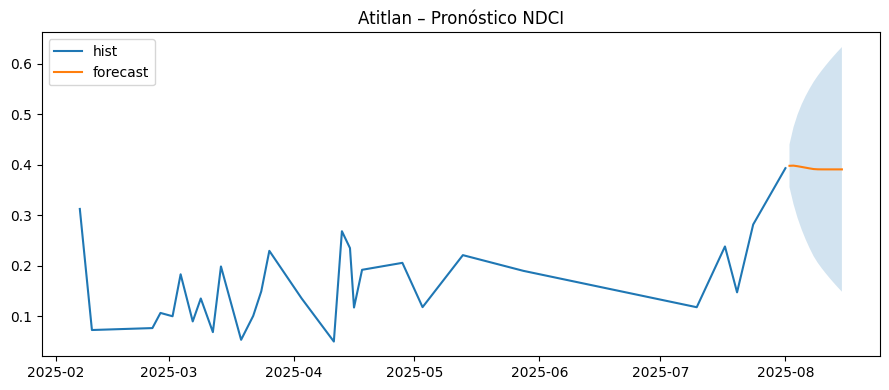

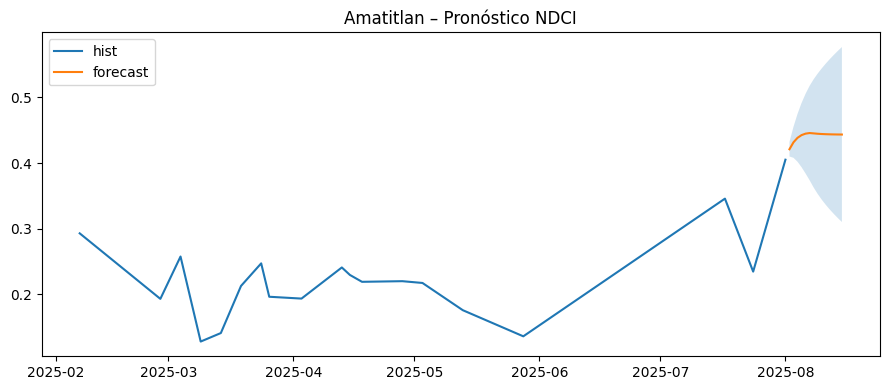

In [32]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def forecast_ndci(ts_df, lake, steps=14):
    d = ts_df[ts_df["lake"]==lake].copy()
    y = pd.to_numeric(d["ndci_mean"], errors="coerce")
    y.index = pd.to_datetime(d["date"])
    y = y.asfreq("D").interpolate()   # relleno simple diario
    model = SARIMAX(y, order=(1,1,1), seasonal_order=(0,0,1,7))
    res = model.fit(disp=False)
    fc = res.get_forecast(steps=steps)
    ci = fc.conf_int()
    plt.figure(figsize=(9,4))
    plt.plot(y.index, y.values, label="hist")
    plt.plot(fc.predicted_mean.index, fc.predicted_mean.values, label="forecast")
    plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.2)
    plt.title(f"{lake.capitalize()} – Pronóstico NDCI"); plt.legend(); plt.tight_layout(); plt.show()
    return res, fc

res_a, fc_a = forecast_ndci(ts, "atitlan")
res_m, fc_m = forecast_ndci(ts, "amatitlan")


In [ ]:
Predicción de cianobacteria en un punto

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

ts["cyanobacteria"] = (ts["ndci_mean"] > 0.15).astype(int)

df_encoded = pd.get_dummies(ts, columns=['lake'], drop_first=True)

X = df_encoded.drop(columns=["date", "cyanobacteria"])
y = df_encoded["cyanobacteria"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42 
)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))


def predict_cyanobacteria(ndci, ndwi, ndvi, lake_name):
    sample = pd.DataFrame([[ndci, ndwi, ndvi, lake_name]],
                         columns=["ndci_mean", "ndwi_mean", "ndvi_mean", "lake"])
    sample_encoded = pd.get_dummies(sample, columns=["lake"])

    for col in X.columns:
        if col not in sample_encoded.columns:
            sample_encoded[col] = 0

    sample_encoded = sample_encoded[X.columns]

    proba = model.predict_proba(sample_encoded)[0][1]
    return {
        "probabilidad cianobacteria": proba,
        "presencia": proba >= 0.5
    }

resultado = predict_cyanobacteria(0.25, -0.1, 0.05, "amatitlan")
print("\nPredicción para punto:", resultado)
resultado = predict_cyanobacteria(0.25, -0.1, 0.05, "atitlan")
print("\nPredicción para punto:", resultado)

Matriz de confusión:
[[3 4]
 [0 3]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      0.43      0.60         7
           1       0.43      1.00      0.60         3

    accuracy                           0.60        10
   macro avg       0.71      0.71      0.60        10
weighted avg       0.83      0.60      0.60        10


Predicción para punto: {'probabilidad cianobacteria': np.float64(0.6964210640440157), 'presencia': np.True_}

Predicción para punto: {'probabilidad cianobacteria': np.float64(0.46581099222524897), 'presencia': np.False_}
